# Actor-Critic Method in Reinforcement Learning

Many algorithms which has great success in today's reinforcement learning (such as, PPO, SAC, etc) include the idea of actor-critic in policy gradient. Now we'll proceed to the next step from vanilla approach of [on-policy learning](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb) and see the idea of this method with A2C intuitively.

Actor-critic is the mixed approach on both value-based Q-Learning and policy-based method.<br>
As we saw in [Q-Learning](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-q-learning.ipynb), $ Q(s_t,a_t) = r_t + \gamma \max_a{Q_t(s_{t+1},a)} $.<br>
As you know, $ \max_a{Q_t(s_{t+1},a)} $ won't depend on action $ a $. Then we can denote $ Q(s_t,a_t) = r_t + \gamma V(s_{t+1}) $ where $ V(s) $ only depends on state $ s $. This $ V(s) $ is called a value-function.<br>
Now we separate $ Q(s_t,a_t) $ into two parts : one is potential value $ V(s_t) $ not depending on $ a_t $, and the other part is $ A(a_t, s_t) $ (which is called **advantage**) depending on $ a_t $ in state $ s_t $. Then it gives :

$$ A(a_t, s_t) = r_t + \gamma V(s_{t+1}) - V(s_t) $$

In this method, we generate a value-function (i.e, fcnet, convnet, etc) $ V(s) $ and apply policy gradient for an advantage-function $ A(a, s) $. (It means that we generate 2 functions and optimize parameters.)

Remind that we applied gradient descent (ascent) on $ E\left[\sum{\gamma r}\right] $ in vanilla policy gradient method. By applying policy gradient on the reduced $ A(a, s) $ instead of $ E\left[\sum{\gamma r}\right] $, we can expect the stable convergence in complex problems, compared with vanilla policy gradient. (See my [early post](https://tsmatz.wordpress.com/2017/09/13/overfitting-for-regression-and-deep-learning/) for bad effects by large values and parameters in deep learning.)<br>
This is based on the idea of Q-Learning, but unlike Q-Learning, you can also operate stochastic and continuous problems with actor-critic.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [ ]:
!pip install numpy gym keras tensorflow==2.4 matplotlib

In [1]:
import gym
import numpy as np
import tensorflow as tf

The idea of actor-critic is similar to [policy gradient example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb).<br>
However, in actor-critic, we use a value function which estimates state value and returns ```v_output``` as follows. (In order to speed up learning, I have reduced the number of hidden neurons, compared with policy gradient example.)

> Note : Here I don't describe details, but you can also use shared network and tune value loss coefficient in optimization. (For simplicy, I set 1.0 for value loss coefficient in the following code.)

In [2]:
s_input = tf.keras.layers.Input(shape=(4, ))

a_hidden = tf.keras.layers.Dense(16,activation="relu")(s_input)
a_output = tf.keras.layers.Dense(2,activation="relu")(a_hidden)

v_hidden = tf.keras.layers.Dense(16,activation="relu")(s_input)
v_output = tf.keras.layers.Dense(1,activation=None)(v_hidden)

policy_pi = tf.keras.Model([s_input], [a_output, v_output])

Now we optimize both policy gradient loss (following ```pi_loss```) and value loss (following ```vf_loss```) as follows.

> Note : The log probability equals to the negative value of cross-entropy error. Same like [policy gradient example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb), I used ```-tf.nn.sparse_softmax_cross_entropy_with_logits()``` to get log probability in the following code.

In [3]:
gamma = 0.99

# pick up action with above distribution policy_pi
def pick_sample(s):
    logits, _ = policy_pi(tf.convert_to_tensor(np.array([s])))
    # return tf.Tensor([[a]], shape=(1, 1), dtype=int64)
    a_tensor = tf.random.categorical(logits, 1)
    # return tf.Tensor([a], shape=(1, 1), dtype=int64)
    a_tensor = tf.squeeze(a_tensor, axis=1)
    # return a
    return int(a_tensor.numpy()[0])

env = gym.make("CartPole-v0")
reward_records = []
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
for i in range(1000):
    # Run episode till done
    done = False
    reward_arr = []
    s = env.reset()
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)

        # Train
        _, v = policy_pi.predict(tf.convert_to_tensor(np.array([s])))
        v = v.item()
        if done:
            v_next = 0
        else:
            _, v_next = policy_pi.predict(tf.convert_to_tensor(np.array([s_next])))
            v_next = v_next.item()
        adv = r + gamma * v_next - v
        with tf.GradientTape() as tape:
            a_output, v_output = policy_pi(tf.convert_to_tensor(np.array([s])), training=True)
            v_output = tf.reshape(v_output, [-1])
            # (See above Note. Calculating log probability as loss)
            log_prob = -tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=a_output,
                labels=tf.convert_to_tensor(np.array([a])))
            pi_loss = -log_prob * adv
            vf_loss = tf.nn.l2_loss(v_output - (r + gamma * v_next))
            grad = tape.gradient(
                pi_loss + vf_loss,
                policy_pi.trainable_variables)
            opt.apply_gradients(zip(grad, policy_pi.trainable_variables))

        reward_arr.append(r)
        s = s_next

    # Output total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, sum(reward_arr)), end="\r")
    reward_records.append(sum(reward_arr))

print("\nDone")
env.close()

Run episode999 with rewards 126.0
Done


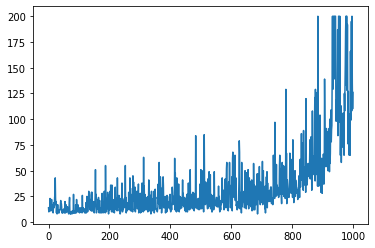

In [4]:
import matplotlib.pyplot as plt
plt.plot(reward_records)